In [1]:
!pwd

/home/dasein/dev/ML_1_project/UDACITY_ML/my_KAGGLE


# Import libraries

In [27]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import  torch
import seaborn as sns

from scipy.stats import skew
from scipy.stats import kurtosis
from tqdm import tqdm

# 1- Exploratory Data Analysis(EDA)

### 1.1 DATA IMPORT

In [2]:
%%time
train_df = pd.read_csv('train.csv', dtype={'acoustic_data' : np.int16, 'time_to_failure':np.float32})

CPU times: user 53.2 s, sys: 3.64 s, total: 56.9 s
Wall time: 58.9 s


In [3]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [4]:
train_df.head(10)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB


### 1.2 Visualization

In [6]:
mini_train_df=pd.read_csv("train.csv",nrows=150000)

In [7]:
mini_train_df.describe()

,acoustic_data,time_to_failure
count,150000.000000,150000.000000
mean,4.884113,1.450182
std,5.101106,0.011248
min,-98.000000,1.430797
25%,3.000000,1.440398
50%,5.000000,1.449999
75%,7.000000,1.459599
max,104.000000,1.469100


In [9]:
mini_train_df.isna().sum()

acoustic_data      0
time_to_failure    0
dtype: int64

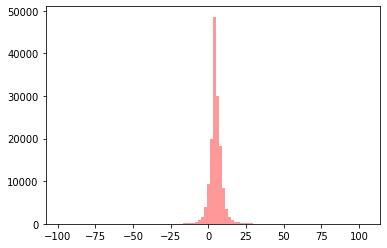

In [13]:
sns.distplot(mini_train_df.acoustic_data.values, color="Red", bins=100, kde=False)

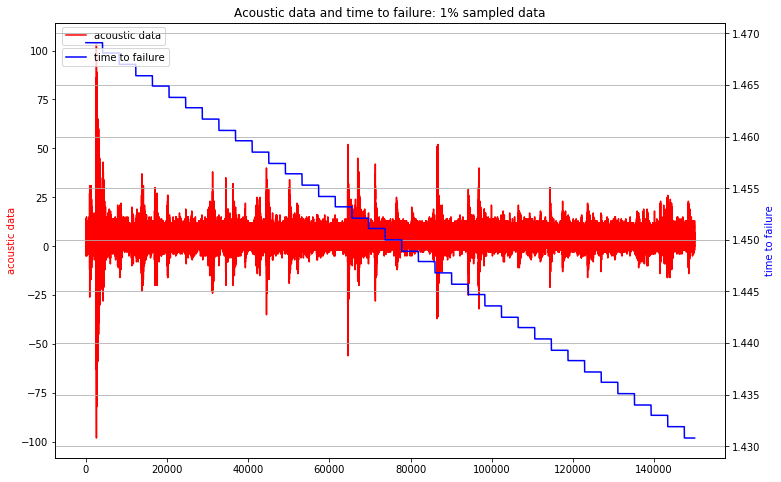

In [11]:
def initial_viusal_plot(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)
initial_viusal_plot(mini_train_df['acoustic_data'], mini_train_df['time_to_failure'])

### 1.3 Data Preprocessing

In [14]:
# Here we take 150,000 rows since data is too large
rows=150000
data_segment=int(np.floor(train_df.shape[0]/rows))
data_segment

4194

In [16]:
X_train = pd.DataFrame(index=range(data_segment), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min','sum','skew','kurt'])
y_train = pd.DataFrame(index=range(data_segment), dtype=np.float64,
                       columns=['time_to_failure'])

In [17]:
y_train.head()

,time_to_failure
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [22]:
X_train.head()

,ave,std,max,min,sum,skew,kurt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.1 Creating features using stastical attributes

In [29]:
%%time

for segment in tqdm(range(data_segment)):
    seg=train_df.iloc[segment*rows:segment*rows+rows] #selecting last 150,000 rows from train segment form train_df
    x=seg['acoustic_data'].values
    y=seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'sum'] = x.sum()
    X_train.loc[segment, 'skew'] =skew(x)
    X_train.loc[segment, 'kurt'] = kurtosis(x)

100%|██████████| 4194/4194 [00:19<00:00, 218.95it/s]

CPU times: user 19.2 s, sys: 7.95 ms, total: 19.2 s
Wall time: 19.2 s


In [44]:
pd.options.display.float_format = '{:.6f}'.format

In [45]:
X_train.head()

,ave,std,max,min,sum,skew,kurt
0,4.884113,5.101089,104.000000,-98.000000,732617.000000,-0.024061,33.661319
1,4.725767,6.588802,181.000000,-154.000000,708865.000000,0.390557,98.755185
2,4.906393,6.967374,140.000000,-106.000000,735959.000000,0.217388,33.554053
3,4.902240,6.922282,197.000000,-199.000000,735336.000000,0.757270,116.544247
4,4.908720,7.301086,145.000000,-126.000000,736308.000000,0.064530,52.976099


In [46]:
y_train.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


--> check for missing data

In [ ]:
def check_missing_data(df):
    flag=df.isna().sum().any()